# MODIS Water XGBOOST Hyperparameter Tuning - Multi-GPU

Version: 0.1.0

Date modified: 02.14.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

import xgboost as xgb

import optuna

import dask
from dask_cuda import LocalCUDACluster
from dask.distributed import Client

from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split 
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
cluster = LocalCUDACluster()
client = Client(cluster)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [3]:
cluster

In [4]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 754.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33653,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: 1 minute ago,Total memory: 754.59 GiB
Comm: tcp://10.100.38.18:40422,Total threads: 1
Dashboard: http://10.100.38.18:40767/status,Memory: 377.29 GiB
Nanny: tcp://127.0.0.1:38013,


In [5]:
FIGURE_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
RASTER_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'
MODEL_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/models/'

GPU = True
TILE = 'global'
MODEL = 'xgboost'
TEST_RATIO = 0.2
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset']
# Columns that the user wants to drop for training purposes. 
colsToDrop = ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1', 'ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [6]:
colsToDrop

['sur_refl_b03_1', 'sur_refl_b04_1', 'sur_refl_b05_1', 'ndwi1', 'ndwi2']

In [7]:
colsToDropTraining

['sur_refl_b03_1',
 'sur_refl_b04_1',
 'sur_refl_b05_1',
 'ndwi1',
 'ndwi2',
 'x_offset',
 'y_offset']

In [8]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :param fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF Dataframe
- Drop unnecessary columns
- Split into Xs and Ys

In [9]:
glob_string = '/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_{}_*.parquet.gzip'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/att/nobackup/cssprad1/projects/modis_water/data/training_data/v1.1.0/MOD09_global_WATER_TR_DATA_#5516128.parquet.gzip']


In [10]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [11]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b06_1
sur_refl_b07_1
ndvi


In [12]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,3285411.0,458.404953,612.980801,-100.0,34.0,314.0,638.0,16000.0
sur_refl_b02_1,3285411.0,1461.324755,1458.106087,-100.0,2.0,1265.0,2651.0,16000.0
sur_refl_b06_1,3285411.0,1203.071787,1150.807727,-100.0,94.0,1046.0,2091.0,16000.0
sur_refl_b07_1,3285411.0,661.418517,780.339095,-100.0,50.0,430.0,985.0,14952.0
ndvi,3285411.0,552.615701,8221.988147,-32762.0,-5294.0,2678.0,6710.0,32762.0


In [13]:
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [14]:
output_interesting_idx(X_train, 'ndvi', 32000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b06_1,sur_refl_b07_1,ndvi
801945,-15,8,83,47,32679
5373445,13,-7,102,40,32203
4413316,-15,8,122,105,32679
2495718,10,-19,38,2,32222
5351120,-24,22,148,119,32144
...,...,...,...,...,...
2703342,-43,23,65,52,32536
1646489,12,-11,95,76,32144
2193244,12,-11,41,23,32144
1798964,-28,15,83,71,32460


## XGBOOST

Choose which combination of hyperparameters to train:

- n_estimators: Number of learners for the xgboost to fit.
- booster: Which booster to use
- lamda: L2 regularization rate
- alpha: L1 regularization rate
- subsample: sampling ration for training data
- colsample_bytree: sampling according to each tree
- max_depth: maximum depth of the tree, signifies complexity
- min_child_weight: minimum child weight, the larger the term, the more complex
- gamme: how selective the algorithm is

In [15]:
from cuml.dask.common import utils as dask_utils    

In [16]:
X_train = dask.dataframe.from_pandas(X_train, npartitions=4)
X_val = dask.dataframe.from_pandas(X_val, npartitions=4)
y_train = dask.dataframe.from_pandas(y_train, npartitions=4)
y_val = dask.dataframe.from_pandas(y_val, npartitions=4)
X_test = dask.dataframe.from_pandas(X_test, npartitions=4)
y_test = dask.dataframe.from_pandas(y_test, npartitions=4)

In [17]:
workers = client.has_what().keys()
workers

dict_keys(['tcp://10.100.38.18:39150', 'tcp://10.100.38.18:40422'])

In [18]:
X_train, y_train = dask_utils.persist_across_workers(client, [X_train, y_train], workers=workers)
X_val, y_val = dask_utils.persist_across_workers(client, [X_val, y_val], workers=workers)
X_test, y_test = dask_utils.persist_across_workers(client, [X_test, y_test], workers=workers)

In [20]:
def objective(trial):
    hyperparameters = {
        "verbosity": 0,
        "learning_rate": 0.003,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "gpu_hist",
        "gpu_id": 0,
        "n_jobs": -1,
        "n_estimators": trial.suggest_categorical("n_estimators", [200]),
        # defines booster, gblinear for linear functions.
        # "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        # L2 regularization weight.
        # "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        # "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        # "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        # "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth":  trial.suggest_int("max_depth", 3, 15, step=1), 
        # minimum child weight, larger the term more conservative the tree.
        # "min_child_weight":  trial.suggest_int("min_child_weight", 2, 10), 
        # "eta":  trial.suggest_float("eta", 1e-8, 1.0, log=True), 
        # defines how selective algorithm is.
        # "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True), 
        # "grow_policy":  trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
    }
    pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation_0-auc")
    classifier = xgb.dask.DaskXGBClassifier(**hyperparameters)
    classifier.client = client
    eval_set = [(X_train, y_train), (X_val, y_val)]
    eval_metric = ["error","auc"]
    classifier.fit(X_train, 
                   y_train, 
                   eval_set=eval_set, 
                   eval_metric=eval_metric, 
                   early_stopping_rounds=5, 
                   callbacks=[pruning_callback],
                   verbose=False)
    preds = classifier.predict(X_test)
    preds = preds.compute()
    y_test_series = y_test.compute()
    cm = confusion_matrix(y_test_series, preds)
    fp = cm[1][0]
    precision = precision_score(y_test_series, preds)
    f1 = f1_score(y_test_series, preds)
    print('Confusion matrix')
    print('TP: {:9} FN: {:9}'.format(cm[0][0], cm[0][1]))
    print('FP: {:9} TN: {:9}'.format(cm[1][0], cm[1][1]))
    print('Precision: {}'.format(precision))
    print('F1 score: {}'.format(f1))
    del classifier, preds
    return fp

## Set the search space

Set the search space for the hyperparameter tuning to search through once. This needs to be in conjunction with the `trial.suggest...` part of the hyperparameters dictionary defined aboce. 

Ex.

If `max_depth` is defined in `hyperparameters` in the `objective` function above as such

`"max_depth":  trial.suggest_int("max_depth", 3, 15, step=1),` 

then we need to pair that with the limited search space below as such:

`search_space={"max_depth":[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}`

This is not the most ideal way of ensuring that trials are not repeated, however it works for now. 

In [21]:
search_space={
    "max_depth":[3, 4, 5, 6, 7, 8, 9],
}

### Set number of trials and timeout

Set the number of trials `n_trials=<num of desired trials>` and the maximum time for the total study `timeout=<timeout in minutes>*60`

In [22]:
optuna.logging.set_verbosity(optuna.logging.INFO)

study = optuna.create_study(study_name='xgboost hyperparameter tuning - multi-gpu', 
                            direction='minimize', 
                            sampler=optuna.samplers.GridSampler(search_space))

study.optimize(objective, n_trials=10, timeout=10*60)

[I 2022-02-17 10:49:19,791] A new study created in memory with name: xgboost hyperparameter tuning - multi-gpu
[10:49:20] task [xgboost.dask]:tcp://10.100.38.18:39150 got new rank 0
[10:49:20] task [xgboost.dask]:tcp://10.100.38.18:40422 got new rank 1
[I 2022-02-17 10:49:31,859] Trial 0 finished with value: 17210.0 and parameters: {'n_estimators': 200, 'max_depth': 8}. Best is trial 0 with value: 17210.0.


Confusion matrix
TP:    548780 FN:     31430
FP:     17210 TN:    497717
Precision: 0.9406025168809423
F1 score: 0.9534132638108027


[10:49:32] task [xgboost.dask]:tcp://10.100.38.18:39150 got new rank 0
[10:49:32] task [xgboost.dask]:tcp://10.100.38.18:40422 got new rank 1
[I 2022-02-17 10:49:35,186] Trial 1 finished with value: 20304.0 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 0 with value: 17210.0.


Confusion matrix
TP:    549676 FN:     30534
FP:     20304 TN:    494623
Precision: 0.9418573874098602
F1 score: 0.9511212555908946


[10:49:35] task [xgboost.dask]:tcp://10.100.38.18:40422 got new rank 0
[10:49:35] task [xgboost.dask]:tcp://10.100.38.18:39150 got new rank 1
[I 2022-02-17 10:49:39,197] Trial 2 finished with value: 19426.0 and parameters: {'n_estimators': 200, 'max_depth': 7}. Best is trial 0 with value: 17210.0.


Confusion matrix
TP:    549644 FN:     30566
FP:     19426 TN:    495501
Precision: 0.9418971347756084
F1 score: 0.9519766684534204


[10:49:39] task [xgboost.dask]:tcp://10.100.38.18:39150 got new rank 0
[10:49:39] task [xgboost.dask]:tcp://10.100.38.18:40422 got new rank 1
[I 2022-02-17 10:49:41,412] Trial 3 finished with value: 18762.0 and parameters: {'n_estimators': 200, 'max_depth': 4}. Best is trial 0 with value: 17210.0.


Confusion matrix
TP:    545817 FN:     34393
FP:     18762 TN:    496165
Precision: 0.9351757960486884
F1 score: 0.9491575680186708


[10:49:41] task [xgboost.dask]:tcp://10.100.38.18:40422 got new rank 0
[10:49:41] task [xgboost.dask]:tcp://10.100.38.18:39150 got new rank 1
[I 2022-02-17 10:49:55,282] Trial 4 finished with value: 17290.0 and parameters: {'n_estimators': 200, 'max_depth': 9}. Best is trial 0 with value: 17210.0.


Confusion matrix
TP:    549721 FN:     30489
FP:     17290 TN:    497637
Precision: 0.9422694584246941
F1 score: 0.954193123455855


[10:49:55] task [xgboost.dask]:tcp://10.100.38.18:40422 got new rank 0
[10:49:55] task [xgboost.dask]:tcp://10.100.38.18:39150 got new rank 1
[I 2022-02-17 10:49:58,735] Trial 5 finished with value: 18069.0 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 0 with value: 17210.0.


Confusion matrix
TP:    545794 FN:     34416
FP:     18069 TN:    496858
Precision: 0.9352198677142115
F1 score: 0.9498327759197325


[10:49:58] task [xgboost.dask]:tcp://10.100.38.18:39150 got new rank 0
[10:49:59] task [xgboost.dask]:tcp://10.100.38.18:40422 got new rank 1
[I 2022-02-17 10:50:00,957] Trial 6 finished with value: 20347.0 and parameters: {'n_estimators': 200, 'max_depth': 3}. Best is trial 0 with value: 17210.0.


Confusion matrix
TP:    545309 FN:     34901
FP:     20347 TN:    494580
Precision: 0.9340845091703007
F1 score: 0.9471011328905945


In [23]:
client.close()

In [24]:
print("Number of finished trials: {}".format(len(study.trials)))
trials = study.best_trials
trial_score = max([trial.values[0] for trial in trials])
best_trial_params = [trial.params for trial in trials if trial.values[0] == trial_score][0]
print(best_trial_params)
print(trial_score)

trial_scores = [trial.values for trial in trials]
trial_params = [trial.params for trial in trials]

for score, param in zip(trial_scores, trial_params):
    print(score)
    for k, v in param.items():
        print("     {}: {}".format(k, v))

study_df = study.trials_dataframe()
study_df.to_csv("hyperopt_tuning_trial_{}_xgboost.csv".format(
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')))

Number of finished trials: 7
{'n_estimators': 200, 'max_depth': 8}
17210.0
[17210.0]
     n_estimators: 200
     max_depth: 8


In [25]:
study_df

,number,value,datetime_start,datetime_complete,duration,params_max_depth,params_n_estimators,system_attrs_grid_id,system_attrs_search_space,state
0,0,17210.0,2022-02-17 10:49:19.810730,2022-02-17 10:49:31.858954,0 days 00:00:12.048224,8,200,5,"{'max_depth': [3, 4, 5, 6, 7, 8, 9]}",COMPLETE
1,1,20304.0,2022-02-17 10:49:31.860657,2022-02-17 10:49:35.185725,0 days 00:00:03.325068,6,200,3,"{'max_depth': [3, 4, 5, 6, 7, 8, 9]}",COMPLETE
2,2,19426.0,2022-02-17 10:49:35.187162,2022-02-17 10:49:39.196840,0 days 00:00:04.009678,7,200,4,"{'max_depth': [3, 4, 5, 6, 7, 8, 9]}",COMPLETE
3,3,18762.0,2022-02-17 10:49:39.198693,2022-02-17 10:49:41.412089,0 days 00:00:02.213396,4,200,1,"{'max_depth': [3, 4, 5, 6, 7, 8, 9]}",COMPLETE
4,4,17290.0,2022-02-17 10:49:41.413699,2022-02-17 10:49:55.282248,0 days 00:00:13.868549,9,200,6,"{'max_depth': [3, 4, 5, 6, 7, 8, 9]}",COMPLETE
5,5,18069.0,2022-02-17 10:49:55.283681,2022-02-17 10:49:58.735475,0 days 00:00:03.451794,5,200,2,"{'max_depth': [3, 4, 5, 6, 7, 8, 9]}",COMPLETE
6,6,20347.0,2022-02-17 10:49:58.738041,2022-02-17 10:50:00.957473,0 days 00:00:02.219432,3,200,0,"{'max_depth': [3, 4, 5, 6, 7, 8, 9]}",COMPLETE


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

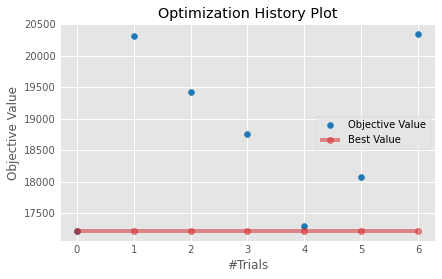

In [26]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<AxesSubplot:title={'center':'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

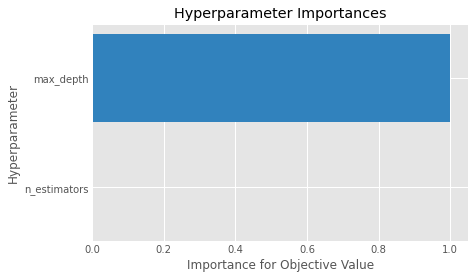

In [27]:
optuna.visualization.matplotlib.plot_param_importances(study)

## Define and train model given the best hyperparameters

In [28]:
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             splitXY=True,
                                             imbalance=False,
                                             trainTestSplit=True,
                                             multi=False)

In [29]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,4380548.0,458.188796,612.458989,-100.0,34.0,314.0,638.0,16000.0
sur_refl_b02_1,4380548.0,1461.059766,1457.966634,-100.0,2.0,1263.0,2650.0,16000.0
sur_refl_b06_1,4380548.0,1202.603051,1150.389895,-100.0,94.0,1045.0,2090.0,16000.0
sur_refl_b07_1,4380548.0,660.987309,779.807629,-100.0,50.0,430.0,985.0,14952.0
ndvi,4380548.0,553.922270,8222.139675,-32762.0,-5294.0,2679.0,6712.0,32762.0


In [30]:
hyperparameters = best_trial_params

base_params = {"verbosity": 0,
               "learning_rate": 0.003,
               "objective": "binary:logistic",
               "tree_method": "hist",
               "n_jobs": -1}

hyperparameters.update(base_params)
print('Using these params:')
pprint(hyperparameters)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["error","auc"]
classifier = xgb.XGBClassifier(**hyperparameters)

Using these params:
{'learning_rate': 0.003,
 'max_depth': 8,
 'n_estimators': 200,
 'n_jobs': -1,
 'objective': 'binary:logistic',
 'tree_method': 'hist',
 'verbosity': 0}


In [31]:
classifier.fit(X_train, y_train, eval_set=eval_set, eval_metric=eval_metric, early_stopping_rounds=10)

[0]	validation_0-error:0.04492	validation_0-auc:0.97918	validation_1-error:0.04529	validation_1-auc:0.97885
[1]	validation_0-error:0.04481	validation_0-auc:0.97927	validation_1-error:0.04523	validation_1-auc:0.97892
[2]	validation_0-error:0.04487	validation_0-auc:0.97928	validation_1-error:0.04530	validation_1-auc:0.97893
[3]	validation_0-error:0.04470	validation_0-auc:0.97933	validation_1-error:0.04509	validation_1-auc:0.97898
[4]	validation_0-error:0.04469	validation_0-auc:0.97937	validation_1-error:0.04509	validation_1-auc:0.97901
[5]	validation_0-error:0.04468	validation_0-auc:0.97945	validation_1-error:0.04509	validation_1-auc:0.97911
[6]	validation_0-error:0.04467	validation_0-auc:0.97946	validation_1-error:0.04509	validation_1-auc:0.97910
[7]	validation_0-error:0.04468	validation_0-auc:0.97948	validation_1-error:0.04510	validation_1-auc:0.97912
[8]	validation_0-error:0.04467	validation_0-auc:0.97949	validation_1-error:0.04508	validation_1-auc:0.97914
[9]	validation_0-error:0.044

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

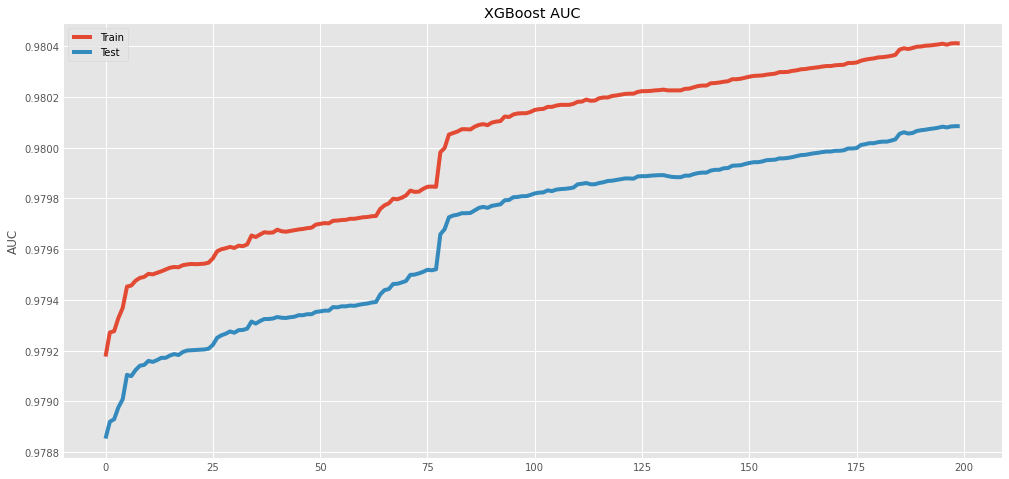

In [32]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Test')
ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

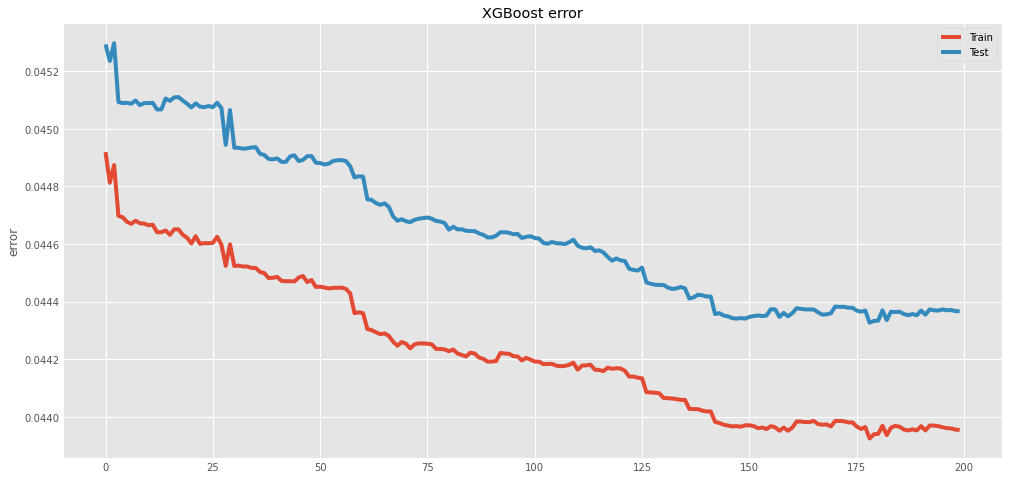

In [33]:
results = classifier.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('XGBoost error')
plt.show()

## Model testing and training/testing data validation

### Get model metrics

In [34]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.956

In [35]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [36]:
test_predictions = test_predictions.astype(np.int16)
y_test_int = y_test.astype(np.int16)

In [37]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96    579164
           1       0.94      0.97      0.95    515973

    accuracy                           0.96   1095137
   macro avg       0.96      0.96      0.96   1095137
weighted avg       0.96      0.96      0.96   1095137

Test Recall
-------------------------------------------------------
0.9459531324460775
Confusion Matrix
-------------------------------------------------------
[[547862  31302]
 [ 17286 498687]]


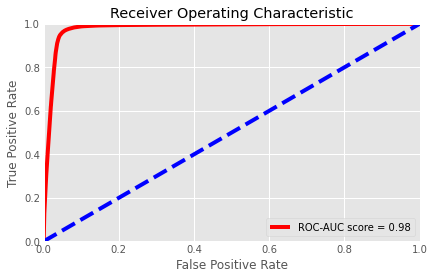

In [38]:
probs = classifier.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC-AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Permutation importance

In [39]:
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=10,
                                                        random_state=42)

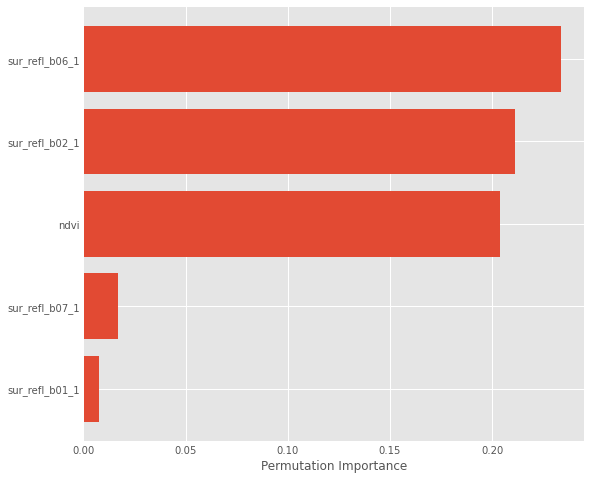

In [40]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.savefig(png_save_path)

In [41]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [42]:
model_save_path = 'mw_{}_{}_{}_{}_tuned_{}.sav'.format(TILE,
                                                      score,
                                                      hyperparameters['n_estimators'],
                                                      MODEL,
                                                      'gpu' if GPU else 'cpu',
                                                      datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /att/nobackup/cssprad1/projects/modis_water/models/mw_global_0.956_200_xgboost_tuned_gpu.sav
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.003, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)


['/att/nobackup/cssprad1/projects/modis_water/models/mw_global_0.956_200_xgboost_tuned_gpu.sav']

# Testing: Raster testing

In [86]:
TILE = 'h12v09'

In [87]:
DAY = 218
YEAR = 2006
PATH = '/att/nobackup/cssprad1/projects/modis_water/data/test_data/{}/'.format(TILE)

In [88]:
vars_list = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list.sort()
vars_list

['/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b01_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b02_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b03_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b04_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b05_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b06_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h12v09/MOD09GA.A2006218.h12v09.061.2020268185436-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [89]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [90]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [91]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[6643 7273 6168 ...  452  962 3003]
 [6643 7273 6168 ...  452  962 3003]
 [6172 6885 5686 ...  546  881 2691]
 ...
 [ 419 2432  206 ... 7060 1580 5026]
 [ 751 2327  316 ... 5120 -404 2895]
 [ 751 2327  316 ... 5120 -404 2895]]
460.8 MB size


In [92]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [93]:
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster


In [94]:
shp = (4800, 4800)
left = list()
right = list()
for i, subarr in enumerate(predictedProbaRaster):
    left.append(subarr[0])
    right.append(subarr[1])
leftArr = np.asarray(left)
rightArr = np.asarray(right)
probaLand = leftArr.reshape(shp)
probaWater = rightArr.reshape(shp)

## Inputreshapet raster: description and histogram

In [95]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,406.319013,434.922643,-28672.0,250.0,306.0,360.0,9953.0
sur_refl_b02_1,23040000.0,3162.238815,649.746304,-28672.0,2923.0,3309.0,3518.0,9242.0
sur_refl_b06_1,23040000.0,1720.846256,526.672817,-28672.0,1506.0,1710.0,1812.0,7103.0
sur_refl_b07_1,23040000.0,530.845410,1843.350129,-28672.0,480.0,547.0,610.0,6316.0
ndvi,23040000.0,7686.235761,2031.676702,-32222.0,7954.0,8349.0,8546.0,32203.0


Text(0.5, 1.0, 'Distribution of each band and calculated idx')

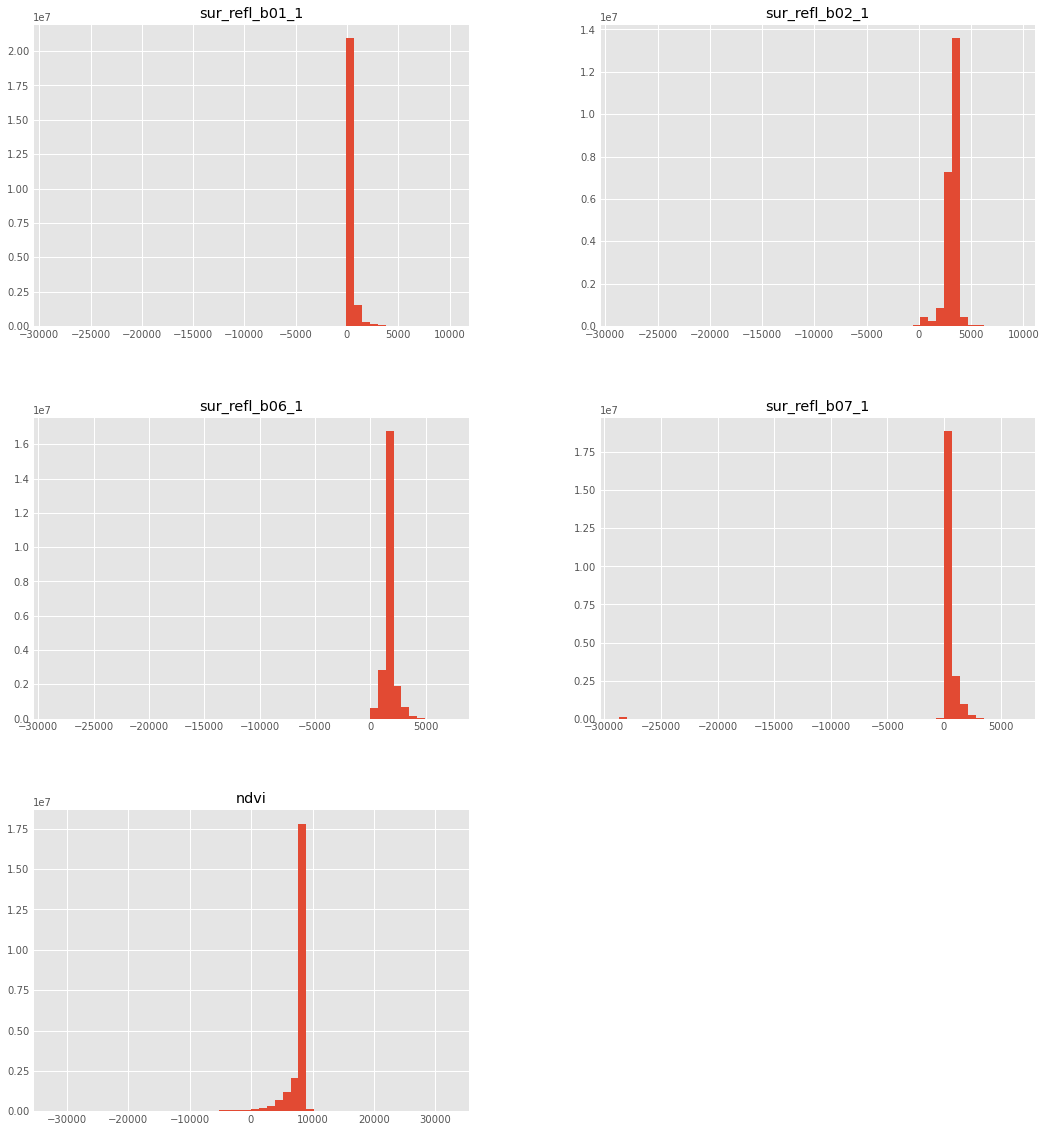

In [96]:
df.hist(figsize=(16, 20), bins=50)
plt.title('Distribution of each band and calculated idx')

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [97]:
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [98]:
qaMask = '/att/nobackup/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray().astype(np.int16)
ds = None
waterMask = None

/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h12v09_min2000_2019.tif
/att/nobackup/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2006218.h12v09.061.2020268185436_bad_good_mask.tif


In [99]:
waterMaskMatrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [100]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

# Generating stats for predicted and truth

## Predicted Raster

In [101]:
TILE = 'global_xgboost_{}'.format(TILE)

Text(0.5, 1.0, 'Predicted water mask')

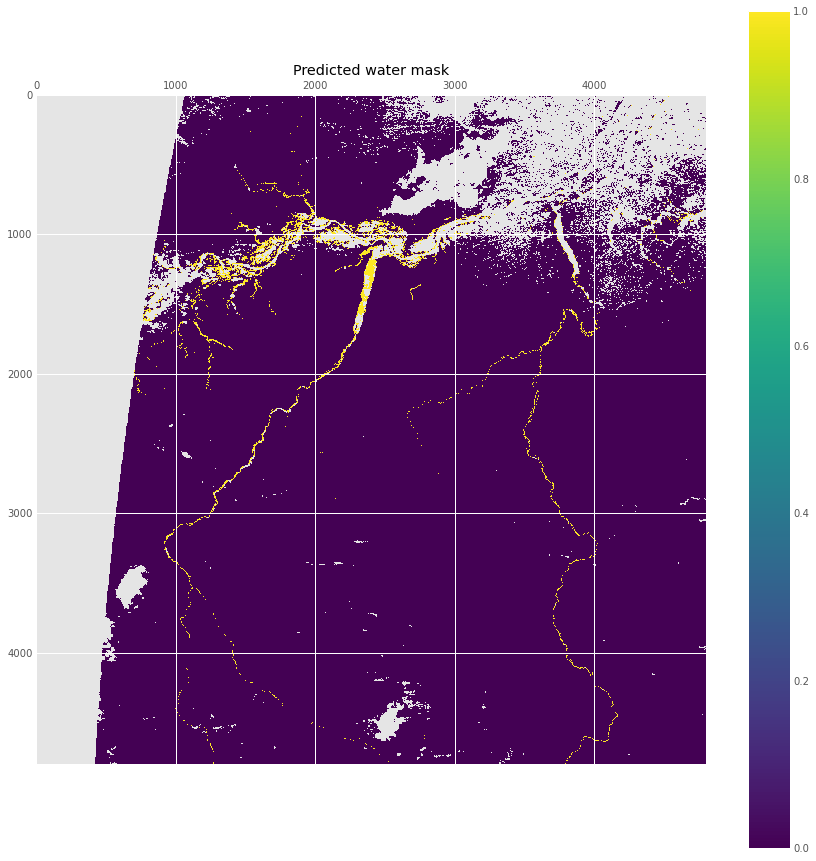

In [102]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResult), fignum=1)
plt.colorbar()
plt.title('Predicted water mask')

## Predicted Probabilities

Text(0.5, 1.0, 'Predicted probabilities of water')

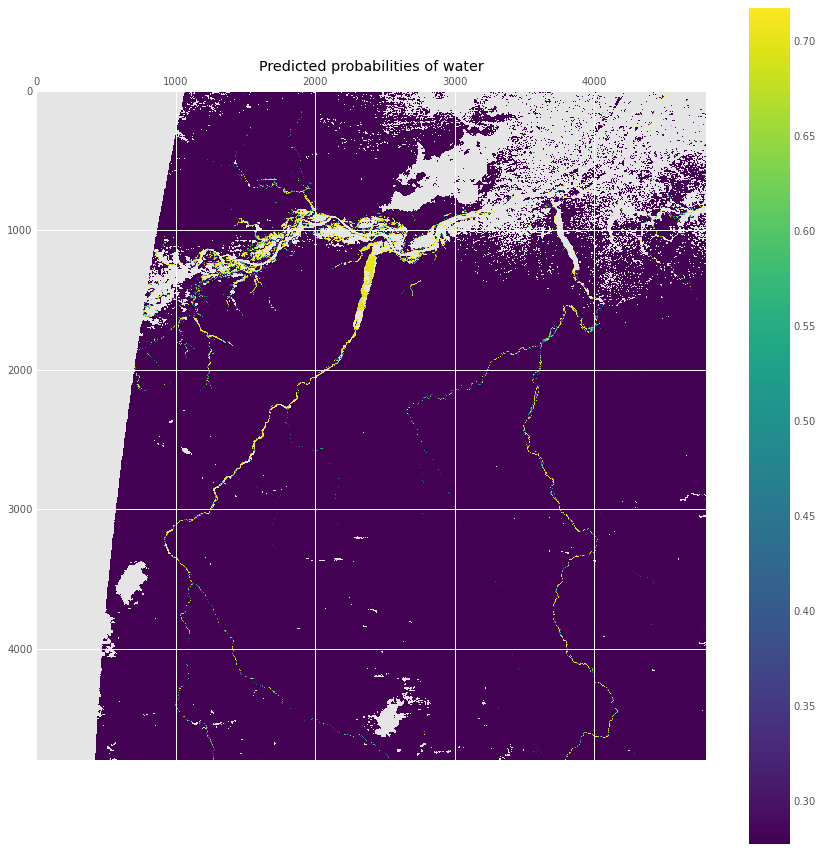

In [103]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResultProba), fignum=1)
plt.colorbar()
plt.title('Predicted probabilities of water')

## Minimum extent water mask

Text(0.5, 1.0, 'Minimum extent water mask')

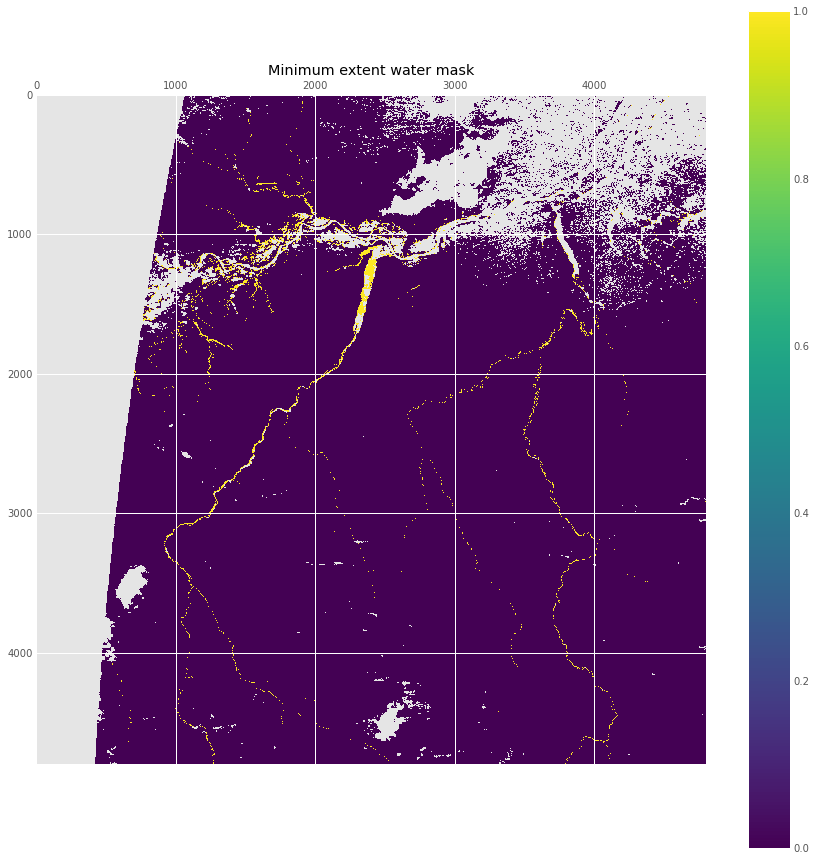

In [104]:
plt.figure(figsize=(15, 15))
truth = np.where(waterMasked==-9999, np.NaN, waterMasked)
truth = np.where(waterMasked==250, np.NaN, truth)
truthPlt = plt.matshow(truth, fignum=1)
plt.colorbar()
plt.title('Minimum extent water mask')

## Metrics on test raster

In [105]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [106]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5364592
 Land occurance: 17430776
 Water occurances: 244632


### Count num of occurences for each class with the water mask

In [107]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5364592
 Land occurance: 17468360
 Water occurances: 207048


### Model metrics on raster data

In [108]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

Metrics of Accuracy for Raster Test Data
True Positives:  155608
True Negatives:  17379336
False Positives: 89024
False Negatives: 51440
Total "good" data: 17675408
Accuracy*: 0.9920531395937225
Precision: 0.6360901272114851
Recall: 0.7515551949306442
f1: 0.6890187743535247


## Output predicted raster to GeoTiff

In [109]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_xgboost_h12v09_predicted_xgboost.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/waterMask_2006_qa_218.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_218_global_xgboost_h12v09_predicted_probabilities_xgboost.tif
Transform
(-6671703.118, 231.656358, 0.0, 0.0, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800
